In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

In [74]:
trades.columns = (
    trades.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

trades = trades[
    ['account','coin','execution_price','size_usd','side',
     'timestamp_ist','closed_pnl','fee']
]

trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    format='%d-%m-%Y %H:%M'
)

trades['date'] = trades['timestamp_ist'].dt.date


In [75]:
sentiment.columns = sentiment.columns.str.strip().str.lower()
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [76]:
merged = pd.merge(
    trades,
    sentiment[['date','classification','value']],
    on='date',
    how='inner'
)


In [77]:
os.makedirs("csv_files", exist_ok=True)
merged.to_csv("csv_files/merged_sentiment_trades.csv", index=False)


In [78]:
profitability = merged.groupby('classification')['closed_pnl'].agg(
    mean='mean', median='median', std='std'
)
profitability


,mean,median,std
classification,,,
Extreme Fear,34.537862,0.0,1136.056091
Extreme Greed,67.892861,0.0,766.828294
Fear,54.290400,0.0,935.355438
Greed,42.743559,0.0,1116.028390
Neutral,34.307718,0.0,517.122220


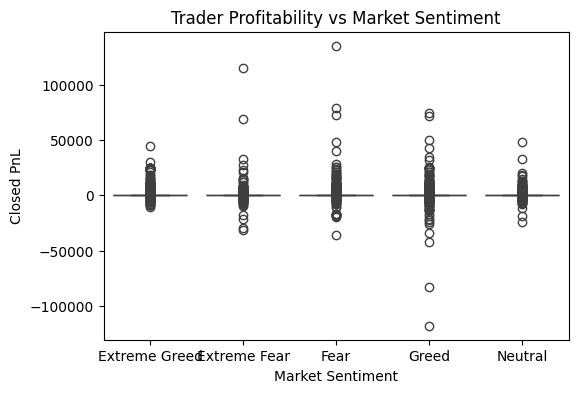

In [79]:
plt.figure(figsize=(6,4))
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title("Trader Profitability vs Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()


In [80]:
risk_metrics = merged.groupby('classification').agg(
    avg_trade_size=('size_usd','mean'),
    avg_fee=('fee','mean')
)
risk_metrics


,avg_trade_size,avg_fee
classification,,
Extreme Fear,5349.731843,1.116291
Extreme Greed,3112.251565,0.675902
Fear,7816.109931,1.495172
Greed,5736.884375,1.254372
Neutral,4782.732661,1.044798


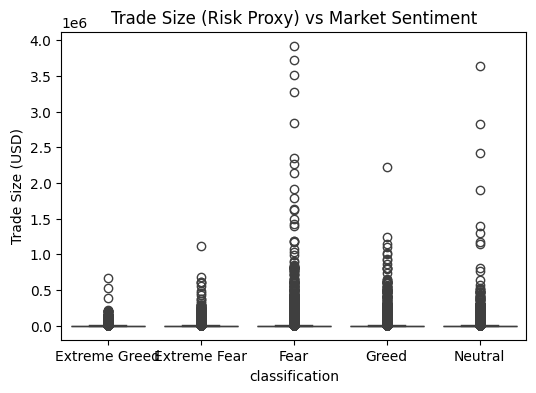

In [81]:
plt.figure(figsize=(6,4))
sns.boxplot(x='classification', y='size_usd', data=merged)
plt.title("Trade Size (Risk Proxy) vs Market Sentiment")
plt.ylabel("Trade Size (USD)")
plt.show()


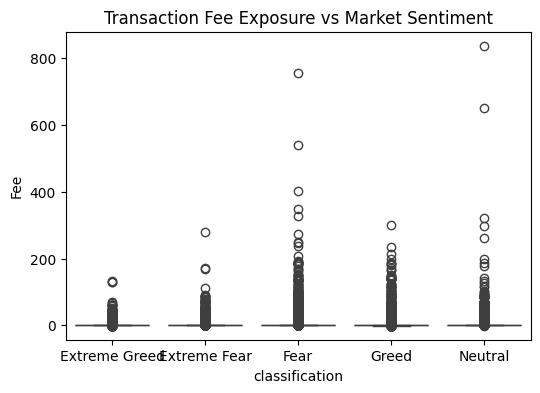

In [82]:
plt.figure(figsize=(6,4))
sns.boxplot(x='classification', y='fee', data=merged)
plt.title("Transaction Fee Exposure vs Market Sentiment")
plt.ylabel("Fee")
plt.show()


In [83]:
volume = merged.groupby('classification')['size_usd'].sum()
volume


,size_usd
classification,
Extreme Fear,1.144843e+08
Extreme Greed,1.244652e+08
Fear,4.833248e+08
Greed,2.885825e+08
Neutral,1.802421e+08


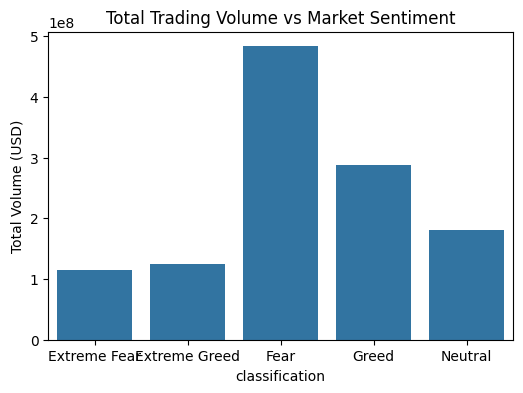

In [84]:
plt.figure(figsize=(6,4))
sns.barplot(x=volume.index, y=volume.values)
plt.title("Total Trading Volume vs Market Sentiment")
plt.ylabel("Total Volume (USD)")
plt.show()


In [85]:
behavior = pd.crosstab(
    merged['side'],
    merged['classification'],
    normalize='columns'
)
behavior


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
side,,,,,
BUY,0.510981,0.44859,0.489513,0.488559,0.503343
SELL,0.489019,0.55141,0.510487,0.511441,0.496657


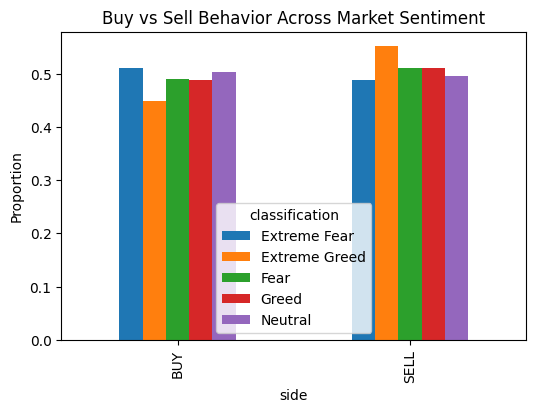

In [86]:
behavior.plot(kind='bar', figsize=(6,4))
plt.title("Buy vs Sell Behavior Across Market Sentiment")
plt.ylabel("Proportion")
plt.show()


In [87]:
volatility = merged.groupby('classification')['closed_pnl'].std()
volatility


,closed_pnl
classification,
Extreme Fear,1136.056091
Extreme Greed,766.828294
Fear,935.355438
Greed,1116.028390
Neutral,517.122220


In [88]:
merged['risk_adjusted_return'] = merged['closed_pnl'] / (merged['size_usd'] + 1)

risk_adjusted = merged.groupby('classification')['risk_adjusted_return'].mean()
risk_adjusted


,risk_adjusted_return
classification,
Extreme Fear,0.004281
Extreme Greed,0.039827
Fear,0.015270
Greed,0.019381
Neutral,0.010111


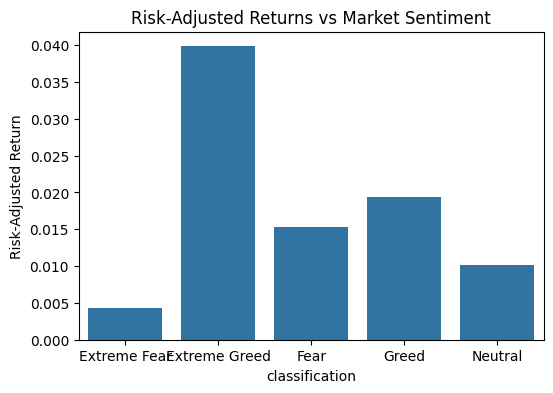

In [89]:
plt.figure(figsize=(6,4))
sns.barplot(x=risk_adjusted.index, y=risk_adjusted.values)
plt.title("Risk-Adjusted Returns vs Market Sentiment")
plt.ylabel("Risk-Adjusted Return")
plt.show()
